# SpectralDefocusCam Iterative Reconstruction Demo

In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import scipy.io
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import utils.psf_utils as psf_utils
import train
import PIL.Image as Image
import numpy, torch
import os, tqdm
import glob

# Change this to GPU or CPU depending on your machine 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = "cuda:0"

%load_ext autoreload
%autoreload 2

/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/site-packages/cupyx/scipy/sparse/_index.py:22: FutureWarning:

In the future `np.bool` will be defined as the corresponding NumPy scalar.



AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
if "cuda" in device:
    import cupy as np
    print(torch.cuda.get_device_name(device))
else:
    import numpy as np


NVIDIA TITAN Xp


### View calibration data and image

In [2]:
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/hatoncar"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [256, 256]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

In [3]:
# calibration matrix
mask = diffuser_utils.load_mask(calib_mat_path_rel, crop_center, crop_size, patch_size)

# psfs (for visualization)
psf_stack = psf_utils.get_lsi_psfs(
    psf_path_rel, 
    blur_levels=num_ims,
    crop_size=crop_size[0], 
    dim=patch_size[0],
    ksizes=ksizes,
    use_first=True,
    exposures=exposures,
    threshold=0.55,
    zero_outside=128,
    blurstride=1
)

NameError: name 'diffuser_utils' is not defined

Drawing plot: 100%|██████████| 5/5 [00:00<00:00, 15.95it/s]


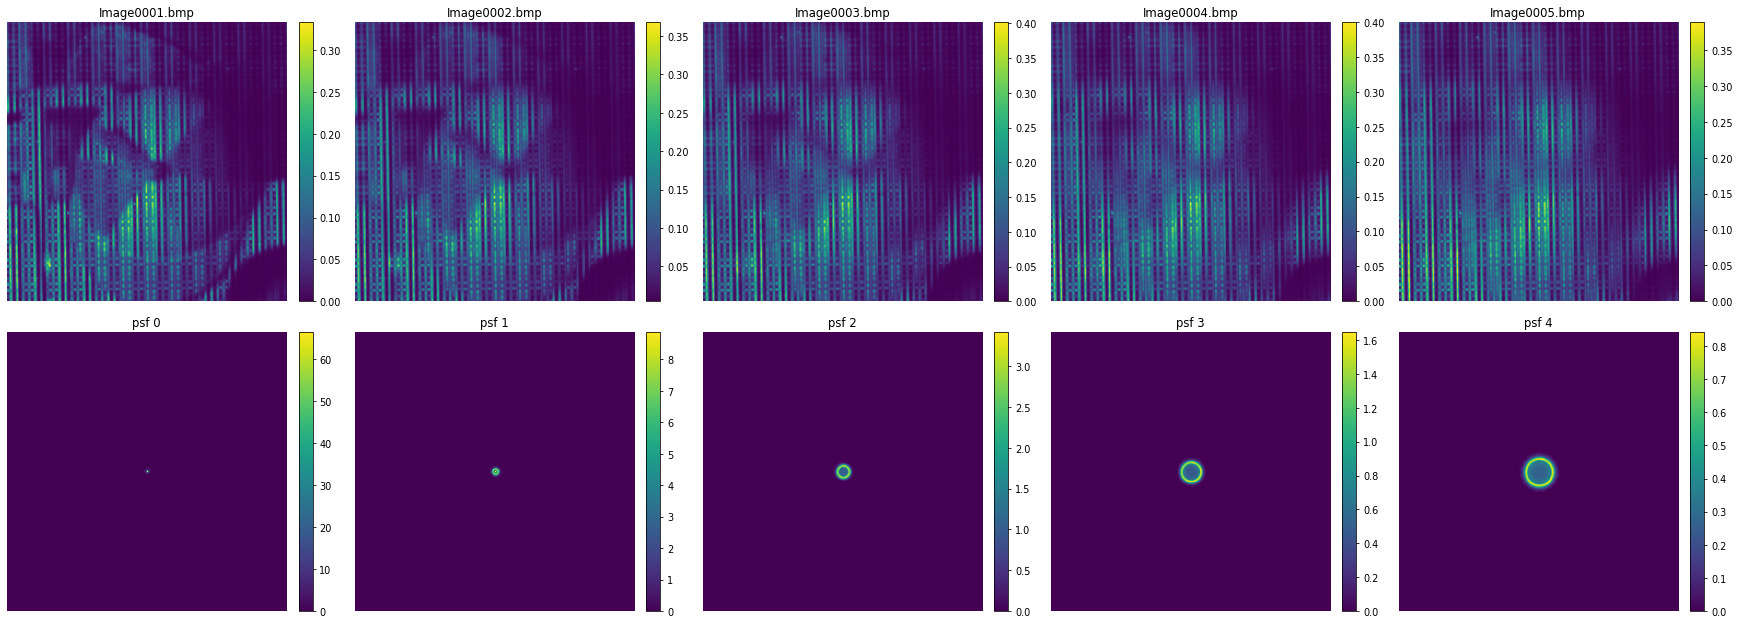

In [32]:
# Experimental measurements
files = sorted(glob.glob(os.path.join(test_meas_path_rel, "*.bmp")))
prep = lambda x: diffuser_utils.preprocess_meas(
    x, 
    center=crop_center,
    crop_size=crop_size[0],
    dim=patch_size[0],
    outlier_std_threshold=3
)
measurements = [prep(numpy.array(Image.open(x))) for x in tqdm.tqdm(files, "Preprocessing")]

fig, ax = plt.subplots(2, len(measurements), figsize=(5*len(measurements), 9), dpi=70)
for i, meas in tqdm.tqdm(list(enumerate(measurements)), "Drawing plot"):
    img1 = ax[0][i].imshow(meas)
    fig.colorbar(img1, ax=ax[0][i], fraction=0.046, pad=0.04)
    img2 = ax[1][i].imshow(psf_stack[i])
    fig.colorbar(img2, ax=ax[1][i], fraction=0.046, pad=0.04)
    ax[0][i].axis('off')
    ax[1][i].axis('off')
    ax[0][i].set_title(os.path.basename(files[i]))
    ax[1][i].set_title(f"psf {i}")

plt.tight_layout()

We can also simualte the psf as a gaussian blur, if we don't trust the psf measurements.

<ipython-input-6-18950768ab1e>:11: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.

<ipython-input-6-18950768ab1e>:11: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

<ipython-input-6-18950768ab1e>:13: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.

<ipython-input-6-18950768ab1e>:13: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



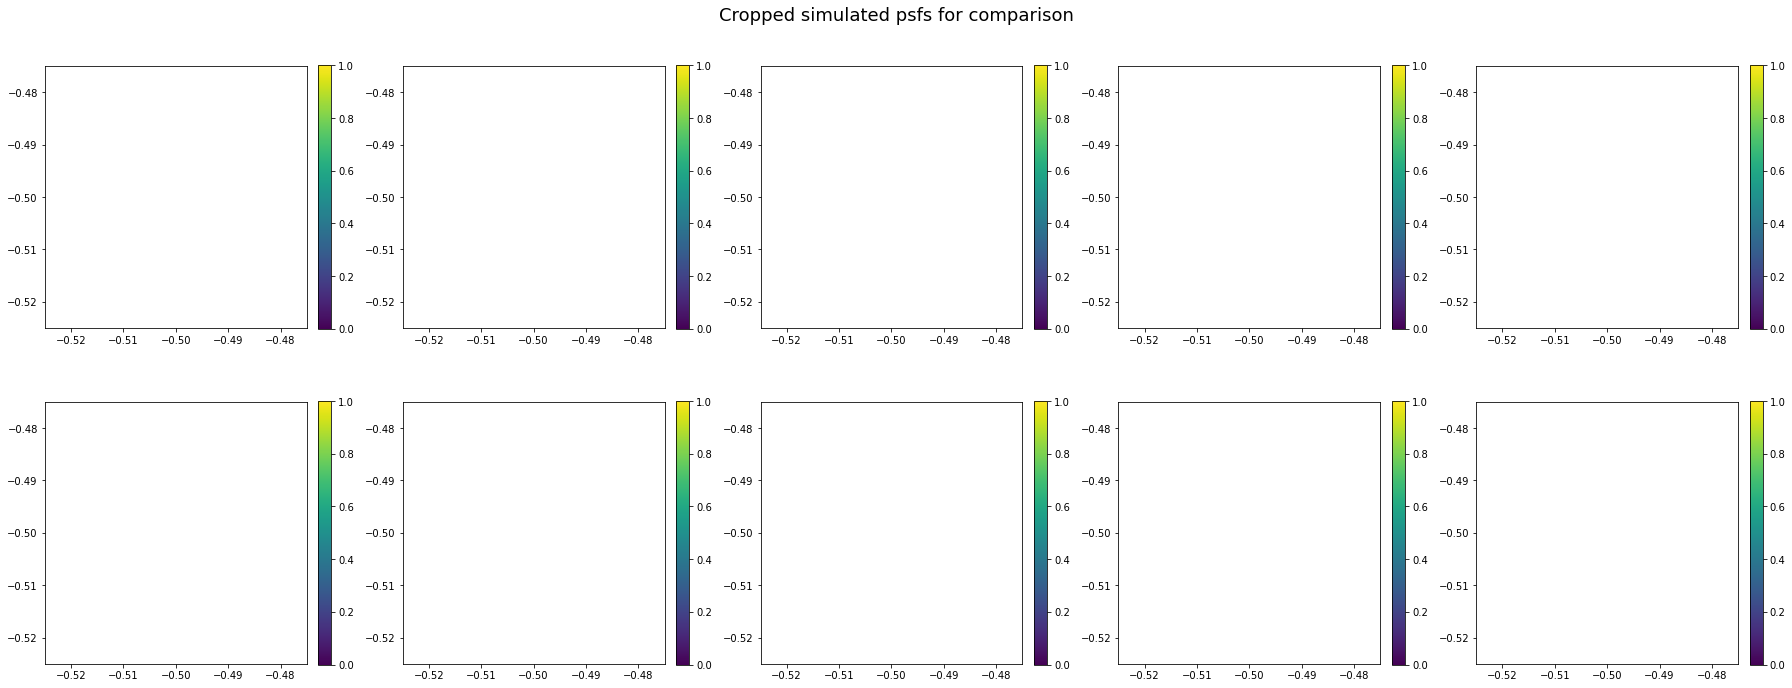

In [6]:
w_init = torch.tensor([0.003, 0.018, 0.04, 0.06, 0.095])
sim_psfs = psf_utils.simulate_gaussian_psf(patch_size[0], w_init)

for i in range(sim_psfs.shape[0]):
    sim_psfs[i] = sim_psfs[i] * 255

#scale psfs
if sim_blur:
    fig, ax = plt.subplots(2,sim_psfs.shape[0], figsize = (sim_psfs.shape[0]*5, 10))
    for i in range(sim_psfs.shape[0]):
        im1 = ax[0,i].imshow(sim_psfs[i][256+64:512-64,256+64:512-64])
        fig.colorbar(im1, ax=ax[0,i], fraction=0.046, pad=0.04)
        im2 = ax[1,i].imshow(psf_stack[i][256+64:512-64,256+64:512-64])
        fig.colorbar(im2, ax=ax[1,i], fraction=0.046, pad=0.04)
    plt.suptitle("Cropped simulated psfs for comparison", fontsize=18)
    plt.tight_layout()
    plt.show()

In [7]:
helper.plot_cube_interactive(mask)

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'a4e350e8-0f88-4955-82e0-b59ec0003223',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 15,  16,  10],
                           [ 24,  29,  64],
                           [ 27,  29, 160],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  18],
                           [  9,  12,  12]],
                   
                          [[ 12,  12,   8],
                           [ 22,  32,  60],
                           [ 28,  53, 170],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  19],
                           [  8,  11,  12]],
                   
                          [[ 13,  13,   8],
                           [ 22,  31,  56],
                           [ 26,  50, 163],
                           ..., 
                           [ 21,  14

### Initialize forward model

In [90]:
stack_depth = 5 # number of images in your stack
blurstride = 1 # stride between ordered blur levels of your measurements

config = {
    "device": device,
    "mask_dir": calib_mat_path_rel,
    "psf_dir": psf_path_rel,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures[:stack_depth*blurstride:blurstride],
            "w_init": w_init,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": False,
            "adjoint": False,
            "spectral_pad": False,
            "roll": False
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 800,
        "prox_method": 'tv',
        "tau": 0.5,
        "tv_lambda": 0.501,
        "tv_lambdaw": 0.001,
        "tv_lambdax": 10,
        "lowrank_lambda": 0.4,
        "print_every": 20
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

sel_meas_stack = torch.tensor(numpy.stack(measurements, axis=0))[:stack_depth*blurstride:blurstride]
model = train.get_model(config, device=device)#, force_psfs=np.array(sim_psfs))
print(sel_meas_stack.shape)


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 64.63it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
device =  None , using GPU and cupy
<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>
torch.Size([5, 256, 256])


## Run model with fista recon

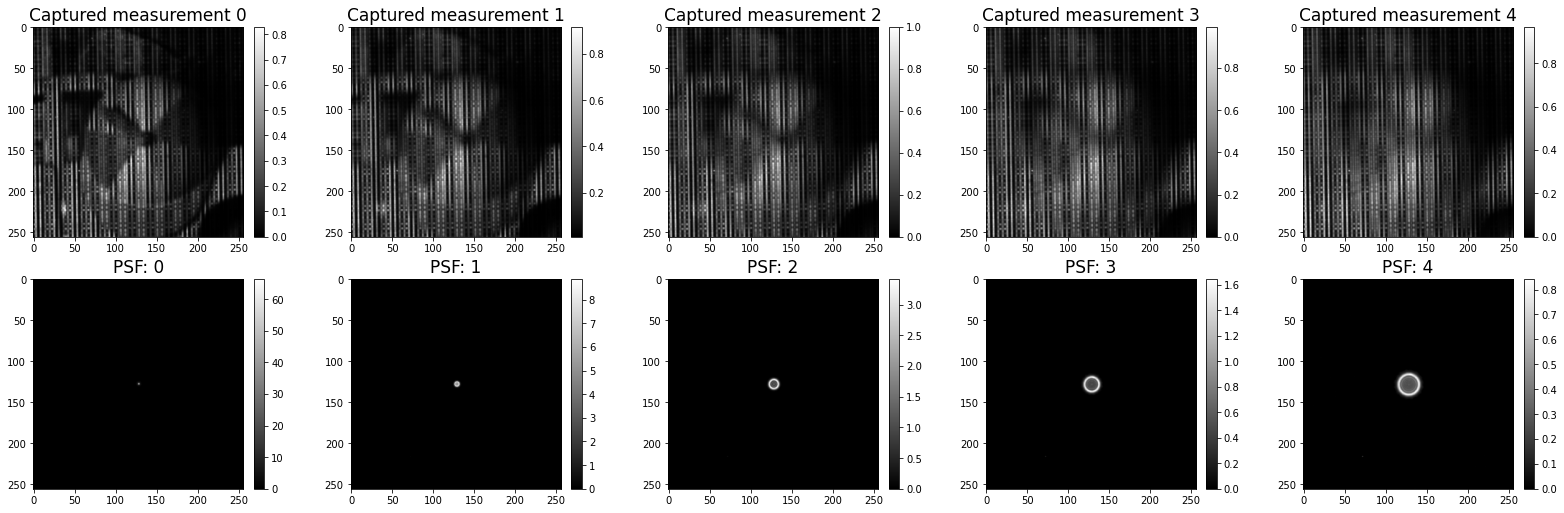

In [91]:
# Let's look at the measurement images and psfs
meas_stack = model.model1(sel_meas_stack.unsqueeze(0).to(device))[0,...]

psfs = model.model2.psfs.get()
num_cols = config["forward_model_params"]["stack_depth"]
fig, ax = plt.subplots(2, num_cols, figsize=(num_cols * 5.5, 8.5))

for i, im in enumerate(meas_stack):
    img1 = ax[0][i].imshow(im.cpu().numpy(), cmap = "gray")
    fig.colorbar(img1, ax=ax[0][i], fraction=0.046, pad=0.04)
    img2 = ax[1][i].imshow(psfs[i], cmap = "gray")
    fig.colorbar(img2, ax=ax[1][i], fraction=0.046, pad=0.04)
    ax[0][i].set_title(f"Captured measurement {i}", fontsize=17)
    ax[1][i].set_title(f"PSF: {i}", fontsize=17)
    
plt.show()

In [92]:
model.model2.iters = 500
model.model2.tv_lambda = 5000 #0.0101
model.model2.tv_lambdax = 0.001 #0.364
model.model2.tv_lambdaw = 0.0001 #0.133
model.model2.print_every = 20

In [86]:
import cupy as cp
model.model2.mask = model.model2.mask * (model.model2.mask > cp.max(model.model2.mask, axis=0) * 0.08)
helper.plot_cube_interactive(model.model2.mask.get())

iteration:  0  loss:  2829.950550792366


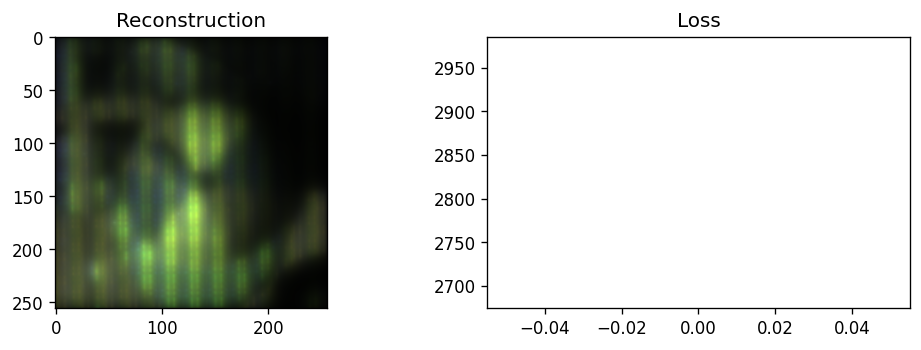

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  20  loss:  195.54667035852268


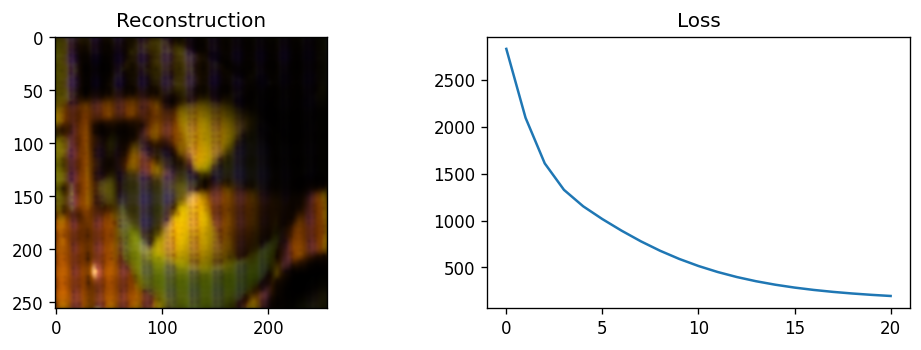

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  40  loss:  103.02428175261936


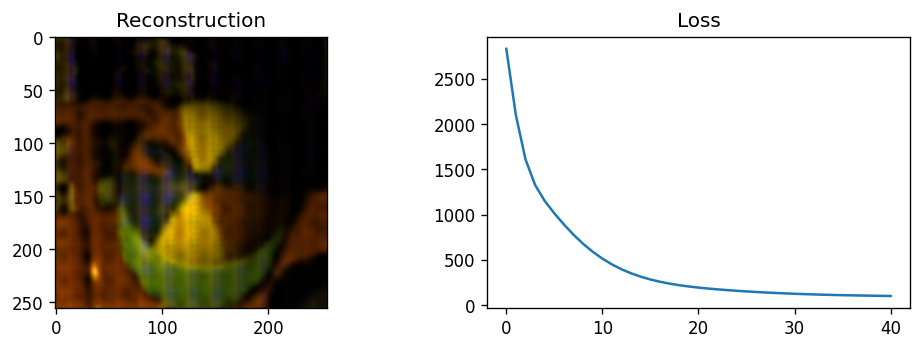

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  60  loss:  90.09176463441324


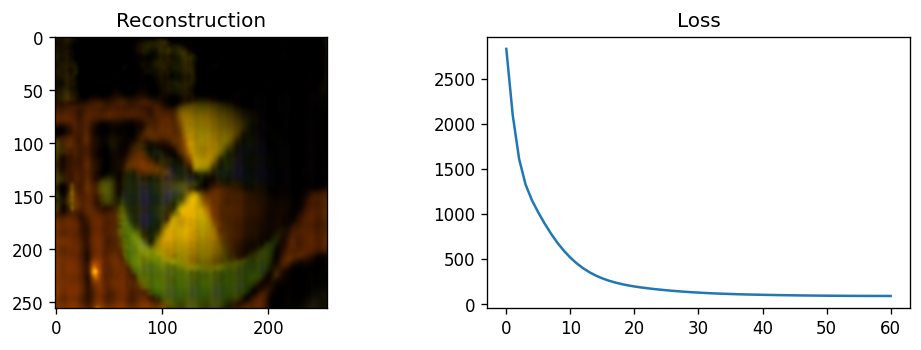

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  80  loss:  92.60040745494435


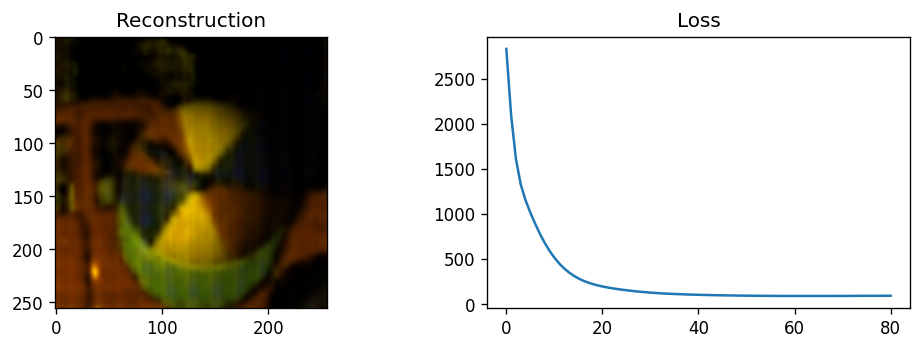

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  100  loss:  94.4643479545072


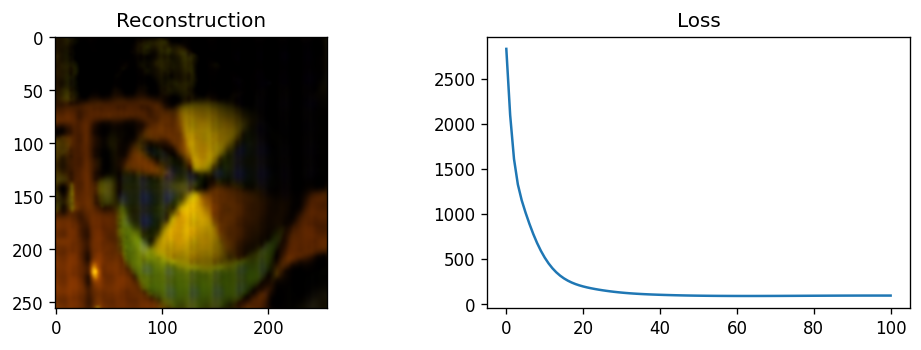

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  120  loss:  92.53233541127776


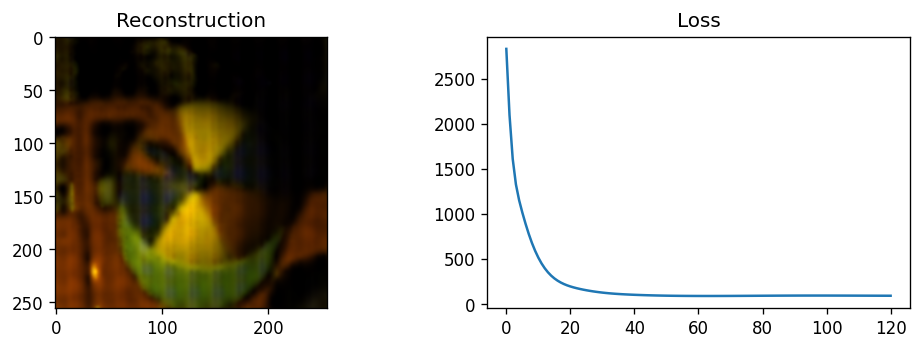

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  140  loss:  92.22486472150857


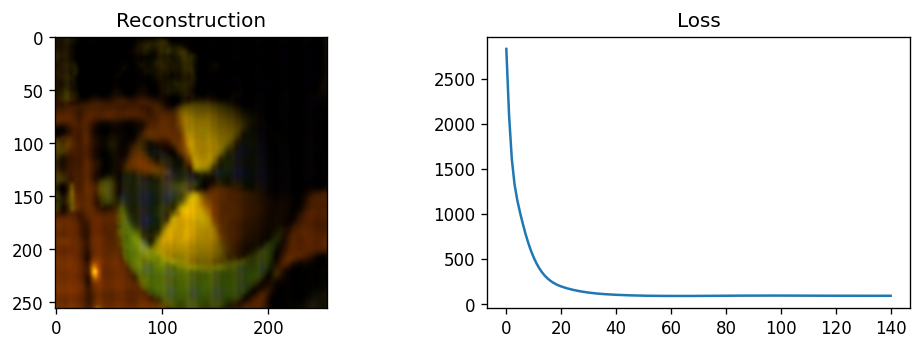

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  160  loss:  93.66948237748085


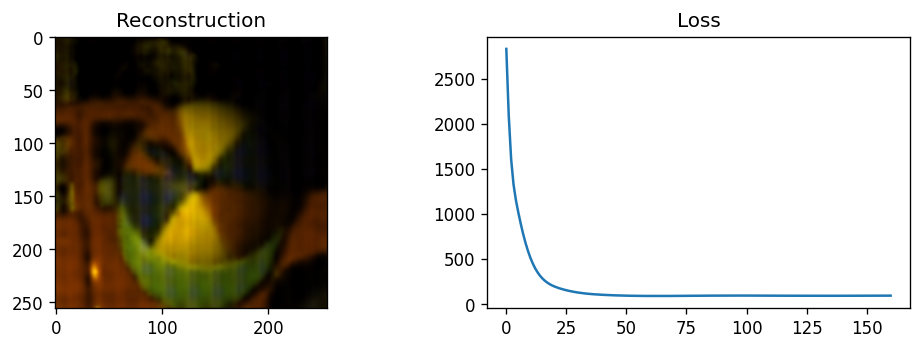

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  180  loss:  93.90572251561977


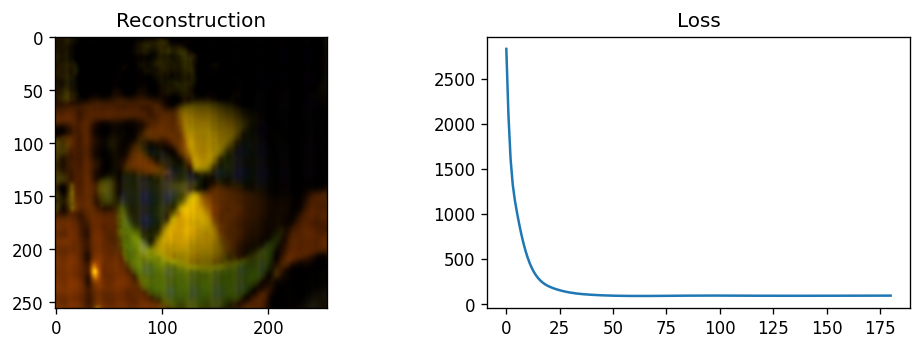

iteration:  200  loss:  93.05901801474675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


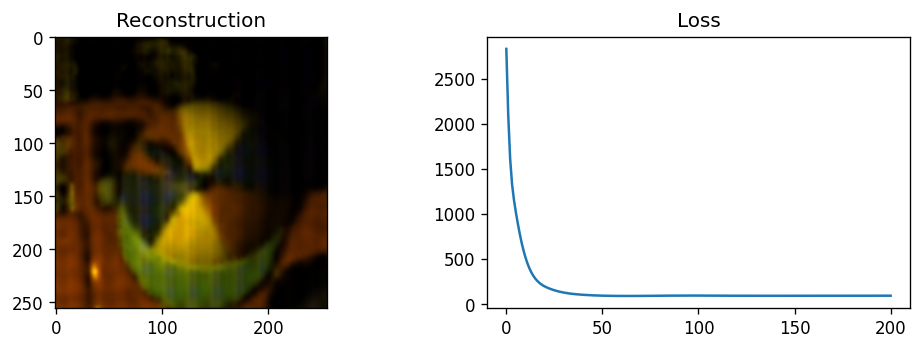

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  220  loss:  92.99794733858931


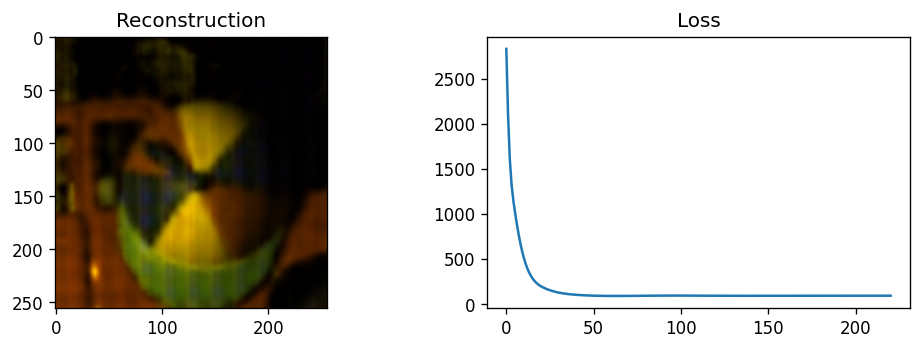

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  240  loss:  93.62225633010408


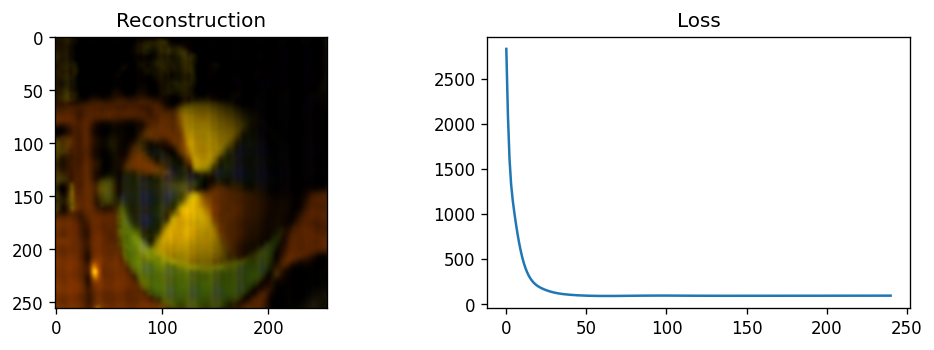

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  260  loss:  93.81235843705575


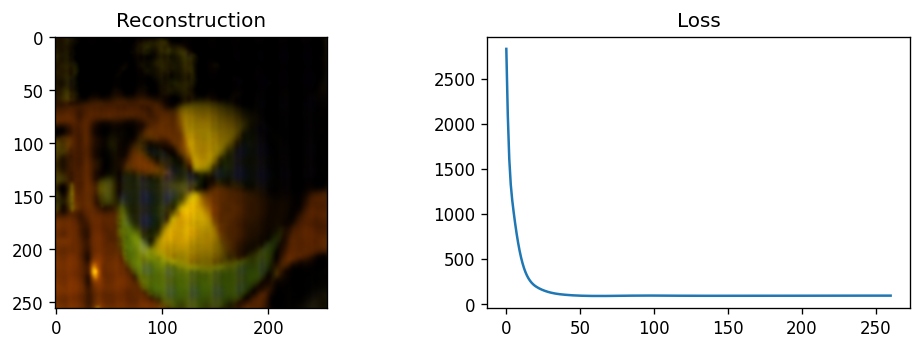

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  280  loss:  93.4961459148709


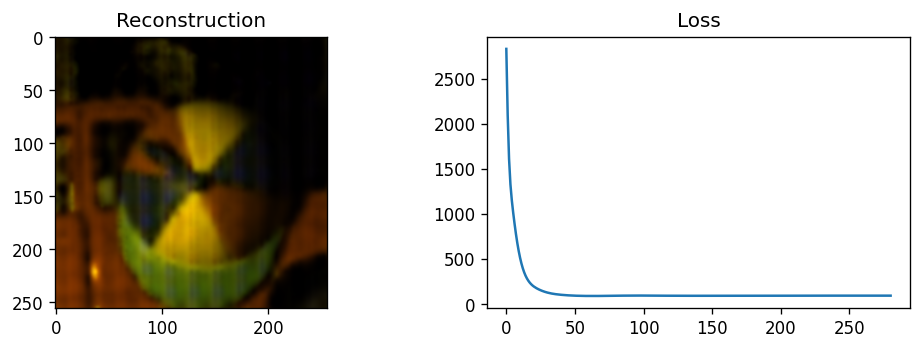

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  300  loss:  93.3416190081531


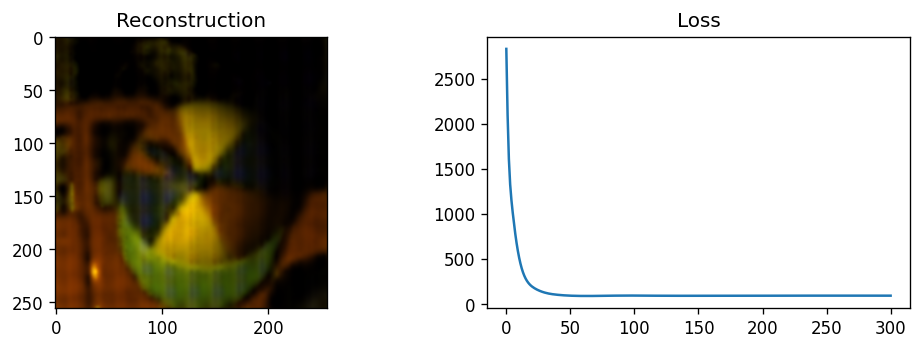

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  320  loss:  93.4808656414058


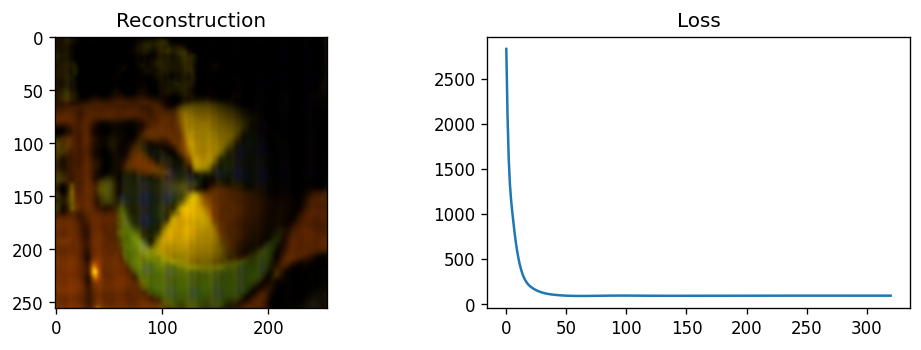

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  340  loss:  93.60364671391902


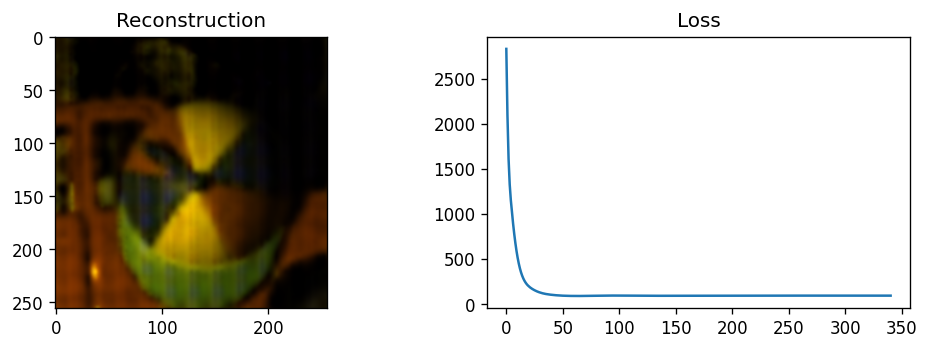

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  360  loss:  93.61161362754089


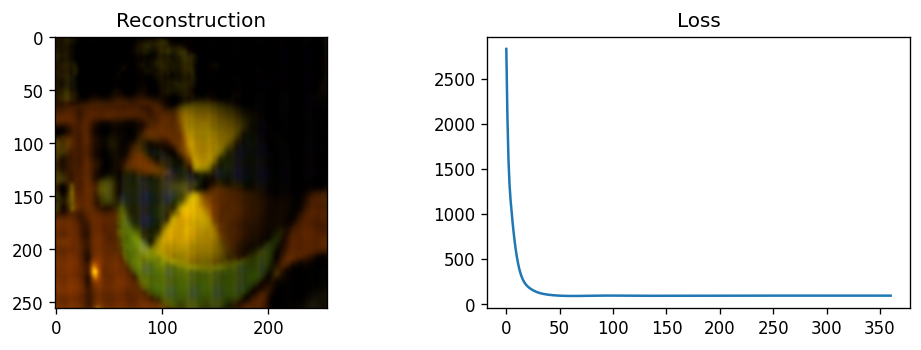

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  380  loss:  93.62145812007967


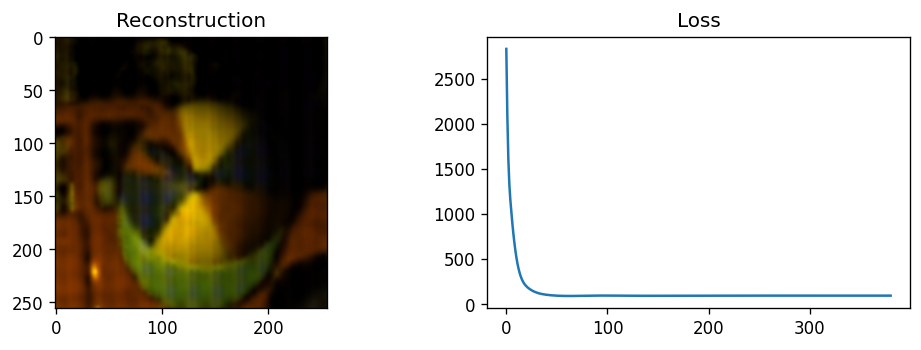

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  400  loss:  93.6536363813042


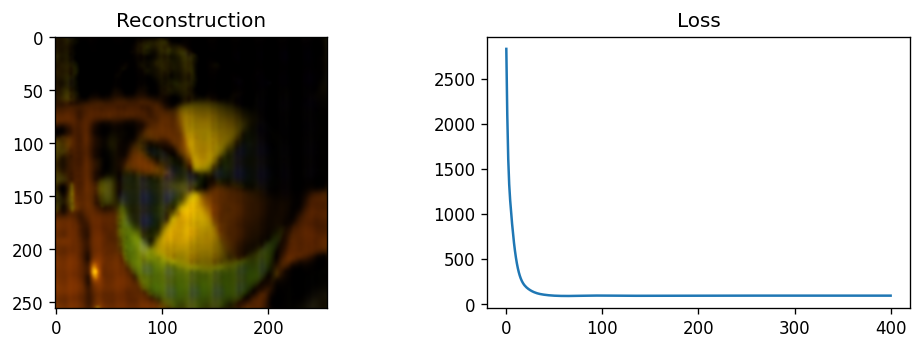

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  420  loss:  93.65857235518837


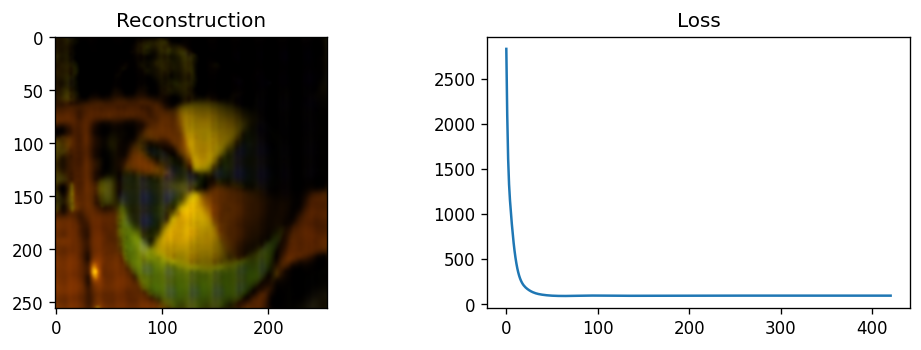

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  440  loss:  93.66372231846725


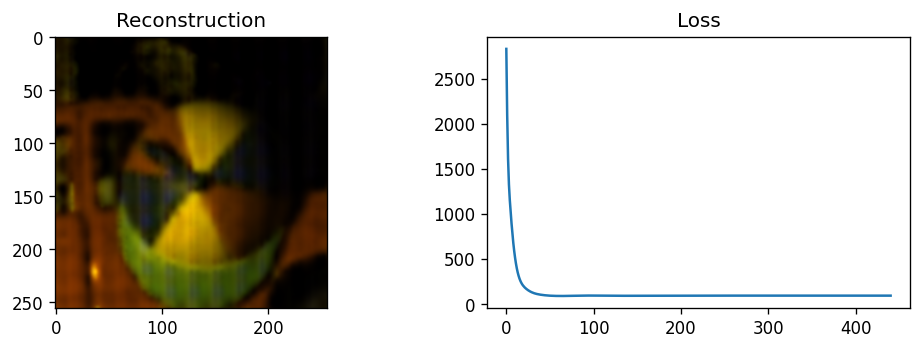

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  460  loss:  93.71065280772872


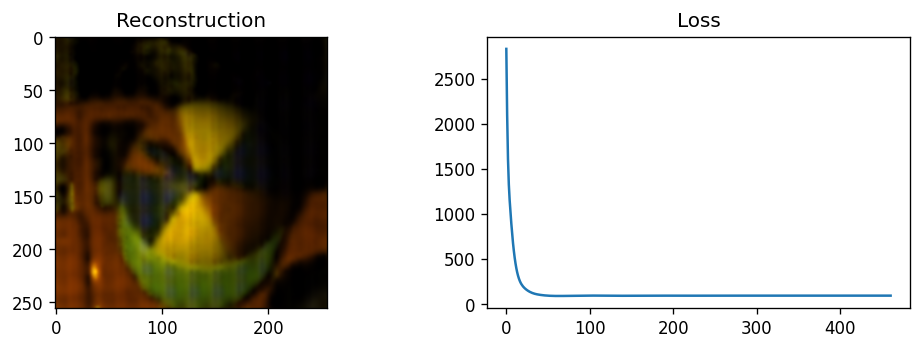

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  480  loss:  93.77021897347771


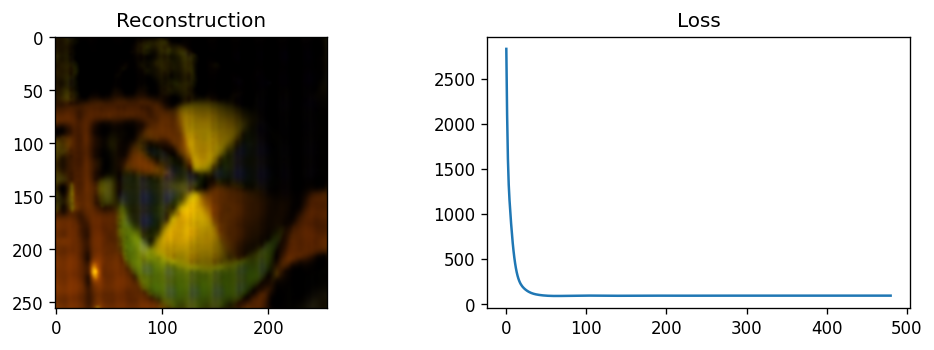

In [93]:
measurement = sel_meas_stack.unsqueeze(0).to(device)
out = model(measurement)

### Visualize Outputs

In [94]:
recon = model.model2.out_img

In [95]:
# Visualize in 3D scan
helper.plt3D(helper.pre_plot(recon, False), title="Spectral Reconstruction")

interactive(children=(IntSlider(value=1, description='r', max=29), Output()), _dom_classes=('widget-interact',…

In [96]:
# Visualize spectra
helper.plot_cube_interactive(recon)

FigureWidget({
    'data': [{'type': 'image',
              'uid': '0f23e626-4da1-418a-921c-26f644e91383',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 41,  30,   4],
                           [ 40,  29,   4],
                           [ 39,  28,   4],
                           ..., 
                           [ 15,  13,   6],
                           [ 18,  16,   8],
                           [ 21,  20,  11]],
                   
                          [[ 40,  29,   4],
                           [ 38,  27,   4],
                           [ 37,  26,   4],
                           ..., 
                           [ 15,  13,   6],
                           [ 18,  17,   8],
                           [ 22,  20,  11]],
                   
                          [[ 38,  27,   4],
                           [ 37,  26,   3],
                           [ 35,  24,   3],
                           ..., 
                           [ 15,  13

In [98]:
helper.plot_cube_interactive(model.model2.mask.get())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '97120bc3-1321-49b7-9f4c-bc194f8a8e0e',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 15,  16,  10],
                           [ 24,  29,  64],
                           [ 27,  29, 160],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  18],
                           [  9,  12,  12]],
                   
                          [[ 12,  12,   8],
                           [ 22,  32,  60],
                           [ 28,  53, 170],
                           ..., 
                           [  6,   8,  26],
                           [  7,  10,  19],
                           [  8,  11,  12]],
                   
                          [[ 13,  13,   8],
                           [ 22,  31,  56],
                           [ 26,  50, 163],
                           ..., 
                           [ 21,  14

In [103]:
helper.plot_cube_interactive(meas_stack.cpu().numpy().transpose(1,2,0))

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'c322e618-baa1-4c88-98a7-5f15ad8ddd80',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[56, 54, 52],
                           [28, 27, 24],
                           [14, 15, 12],
                           ..., 
                           [ 3,  4,  3],
                           [10, 11, 10],
                           [35, 35, 33]],
                   
                          [[72, 69, 67],
                           [35, 34, 31],
                           [20, 21, 17],
                           ..., 
                           [ 3,  4,  2],
                           [10, 11, 10],
                           [34, 34, 32]],
                   
                          [[72, 69, 69],
                           [36, 35, 33],
                           [20, 20, 17],
                           ..., 
                           [ 3,  4,  3],
                           [10, 11,  9],

In [16]:
recon.shape

(256, 256, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


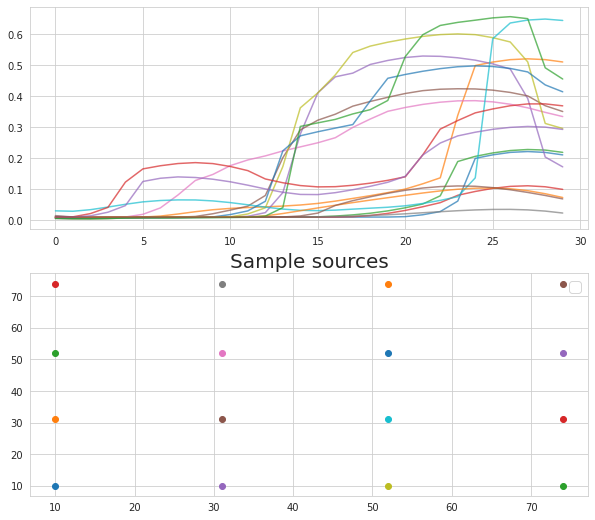

In [97]:
import seaborn
seaborn.set_style("whitegrid")

recon_norm = (recon - np.min(recon)) / np.max(recon - np.min(recon))
fig, ax = plt.subplots(2,1, figsize=(10,9))
for i in range(30, recon.shape[0], recon.shape[0]//4):
    for j in range(30, recon.shape[1], recon.shape[1]//4):
        ax[0].plot(recon_norm[i,j], alpha=0.7)
        ax[1].scatter(i//3,j//3)

ax[1].set_title("Sample sources", fontsize=20)
plt.legend(fontsize=15, loc="upper right")
plt.show()